# advanced dynamic seq2seq
https://github.com/ematvey/tensorflow-seq2seq-tutorials
Encoder is bidirectional now. Decoder is implemented using tf.nn.raw_rnn. It feeds previously generated tokens during training as inputs, instead of target sequence.
![](../data/2-seq2seq-feed-previous.png)

In [1]:
import helpers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
tf.reset_default_graph()
sess= tf.InteractiveSession()

In [2]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

In [3]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [4]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [5]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)
((encoder_fw_outputs, encoder_bw_outputs),(encoder_fw_final_state, encoder_bw_final_state))=\
tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell, cell_bw=encoder_cell, inputs=encoder_inputs_embedded,dtype=tf.float32,time_major=True)

In [6]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [7]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [8]:
encoder_outputs = tf.concat((encoder_fw_outputs,encoder_bw_outputs),-1)
encoder_final_state_c = tf.concat((encoder_fw_final_state.c, encoder_bw_final_state.c),-1)
encoder_final_state_h = tf.concat((encoder_fw_final_state.h, encoder_bw_final_state.h),-1)
encoder_final_state = tf.contrib.rnn.LSTMStateTuple(c=encoder_final_state_c, h=encoder_final_state_h)

In [9]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'concat_1:0' shape=(?, 40) dtype=float32>, h=<tf.Tensor 'concat_2:0' shape=(?, 40) dtype=float32>)

In [11]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

In [12]:
batch_size

<tf.Tensor 'unstack:1' shape=() dtype=int32>

In [13]:
decoder_lengths = encoder_inputs_length + 3
# +2 additional steps, +1 leading <EOS> token for decoder inputs
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [24]:
def loop_fn(time, cell_output, cell_state, loop_state):
    emit_output = cell_output  # == None for time == 0
    if cell_output is None:  # time == 0
        elements_finished = (0 >= decoder_lengths)
        next_input = eos_step_embedded
        next_cell_state = encoder_final_state
        emit_output = None
        next_loop_state = None
    else:
        def get_next_input():
            output_logits = tf.add(tf.matmul(cell_output, W), b)
            prediction = tf.argmax(output_logits, 1)
            return tf.nn.embedding_lookup(embeddings, prediction)
        elements_finished = (time >= decoder_lengths)
        finished = tf.reduce_all(elements_finished) 
        next_input = tf.cond(finished,lambda: pad_step_embedded,get_next_input)
        next_cell_state = cell_state
        elements_finished = (time >= decoder_lengths)
            
        next_loop_state = None
    return (elements_finished, next_input, next_cell_state,
          emit_output, next_loop_state)


In [25]:
decoder_outputs_ta, decoder_final_state, _ =tf.nn.raw_rnn(decoder_cell,loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [26]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [27]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))
decoder_prediction = tf.argmax(decoder_logits, 2)

In [28]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [29]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[5, 4, 4, 5, 7]
[2, 9, 8, 9, 6, 8]
[3, 7, 2, 7]
[8, 6, 5, 6, 4, 9, 9]
[6, 7, 3, 8, 5, 7, 7, 4]
[8, 4, 6, 3, 6, 3]
[4, 2, 5, 3, 4, 2, 6, 6]
[6, 3, 3, 2]
[5, 9, 9, 4, 2]
[9, 4, 8, 3]


In [36]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_inputs_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch([(sequence)+[EOS]+[PAD]*2 for sequence in batch])
    return{
        encoder_inputs:encoder_inputs_,
        decoder_targets:decoder_targets_,
        encoder_inputs_length:encoder_inputs_lengths_
    }

In [37]:
sess.run(tf.global_variables_initializer())
loss_track = []
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.3633852005004883
  sample 1:
    input     > [3 7 6 9 7 3 7 0]
    predicted > [1 1 1 1 1 1 1 1 1 1 0]
  sample 2:
    input     > [2 7 5 6 2 3 4 8]
    predicted > [0 1 1 1 1 1 1 1 1 1 1]
  sample 3:
    input     > [3 2 2 3 5 5 7 2]
    predicted > [8 8 8 1 1 1 1 1 1 1 1]

batch 1000
  minibatch loss: 0.5249336361885071
  sample 1:
    input     > [4 8 7 0 0 0 0 0]
    predicted > [4 8 7 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [7 7 7 4 5 0 0 0]
    predicted > [7 7 7 4 5 1 0 0 0 0 0]
  sample 3:
    input     > [8 6 8 4 4 7 5 7]
    predicted > [8 8 6 4 4 5 5 7 1 0 0]

batch 2000
  minibatch loss: 0.2231345921754837
  sample 1:
    input     > [8 8 4 6 6 7 9 0]
    predicted > [8 8 4 6 6 7 9 1 0 0 0]
  sample 2:
    input     > [7 4 7 5 2 8 4 4]
    predicted > [7 4 7 5 2 8 4 4 1 0 0]
  sample 3:
    input     > [4 5 9 9 0 0 0 0]
    predicted > [4 5 9 9 1 0 0 0 0 0 0]

batch 3000
  minibatch loss: 0.1286967396736145
  sample 1:
    input     > [7 6 9

loss 0.1318 after 300100 examples (batch_size=100)


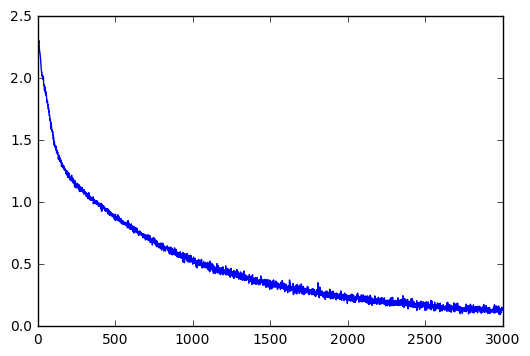

In [38]:
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))